In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

# from matplotlib.path import Path
# %matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [4]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
# labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l != l]
# labels_to_sample = structures + [l + '_negative' for l in structures]
labels_to_sample = structures + [l + '_negative' for l in structures] + \
[convert_to_surround_name(l, margin=m, suffix=surr_l) for m in [100,200,300,400,500,600,700,800,900,1000]
 for l in structures for surr_l in structures + ['noclass'] if surr_l != l] + \
['noclass']

# Training

In [5]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels = set([])

for stack in all_annotated_nissl_stacks:
# for stack in ['MD635']:
    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=1000)
    
    for name, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [8]:
# # Optional, if no need to sample training patches

# labels = set([])

# # for stack in ['MD589', 'MD585', 'MD594']:
# for stack in ['MD635']:
#     annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
#     label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
#     labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
#     labels = labels | labels_this_stack

In [6]:
existing_names = set([convert_to_original_name(l) for l in labels]) - {'noclass'}

In [ ]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

In [21]:
# Remove addresses whose features are None
for name in labels:
    valid = [(ftr, addr) for ftr, addr in zip(training_features[name], training_addresses[name])
                if ftr is not None]
    res = zip(*valid)
    training_features[name] = np.array(res[0])
    training_addresses[name] = res[1]

In [22]:
for name in sorted(training_addresses.iterkeys()):
    print name, len(training_addresses[name])

10N 2609
10N_negative 2980
10N_surround_1000_12N 3000
10N_surround_1000_AP 886
10N_surround_1000_noclass 3000
10N_surround_100_12N 10
10N_surround_100_noclass 3000
10N_surround_200_12N 1878
10N_surround_200_noclass 3000
10N_surround_300_12N 3000
10N_surround_300_AP 13
10N_surround_300_noclass 3000
10N_surround_400_12N 3000
10N_surround_400_AP 127
10N_surround_400_noclass 3000
10N_surround_500_12N 3000
10N_surround_500_AP 367
10N_surround_500_noclass 3000
10N_surround_600_12N 3000
10N_surround_600_AP 554
10N_surround_600_noclass 3000
10N_surround_700_12N 3000
10N_surround_700_AP 673
10N_surround_700_noclass 3000
10N_surround_800_12N 3000
10N_surround_800_AP 771
10N_surround_800_noclass 3000
10N_surround_900_12N 3000
10N_surround_900_AP 833
10N_surround_900_noclass 3000
12N 3000
12N_negative 2978
12N_surround_1000_10N 2470
12N_surround_1000_AP 3000
12N_surround_1000_noclass 3000
12N_surround_100_10N 8
12N_surround_100_noclass 3000
12N_surround_200_10N 1586
12N_surround_200_noclass 3000
1

In [31]:
if stack in all_annotated_ntb_stacks:
    clf_rootdir = CLF_NTBLUE_ROOTDIR
elif stack in all_annotated_nissl_stacks:
    clf_rootdir = CLF_NISSL_ROOTDIR
else:
    raise

Setting environment for Gordon


In [59]:
# structure_centers_all_stacks_all_secs_all_names = defaultdict(lambda: defaultdict(dict))

# for stack in all_annotated_nissl_stacks:
#     print stack
    
#     contours_original, _ = DataManager.load_annotation_v3(stack=stack)
#     contours_aligned_cropped = convert_annotation_v3_original_to_aligned_cropped(contours_original, stack=stack)    
    
#     first_sec, last_sec = metadata_cache['section_limits'][stack]
    
#     for sec in range(first_sec, last_sec+1):

#         fn = metadata_cache['sections_to_filenames'][stack][sec]
#         if fn in ['Nonexisting', 'Rescan', 'Placeholder']:
#             continue

#         contours_this_sec = contours_aligned_cropped[contours_aligned_cropped['filename'] == fn]

#         for name_u in set(contours_this_sec['name']):
#             matched_contours = contours_this_sec[(contours_this_sec['name'] == name_u)]
#     #         assert len(matched_contours) == 1 # will fail because the bug in GUI that creates multiple duplicate entries for the same contour
#             cnt = matched_contours.iloc[0]
#             center = cnt['vertices'].mean(axis=0)
#             structure_centers_all_stacks_all_secs_all_names[stack][sec][name_u] = center

# structure_centers_all_stacks_all_secs_all_names.default_factory = None

MD585
'No object named structures in the file'


Annotation has no structures.


MD589
'No object named structures in the file'


Annotation has no structures.


MD594
'No object named structures in the file'


Annotation has no structures.


In [61]:
# distances_to_structures = apply_function_to_dict(lambda addrs:\
#                                                  addresses_to_structure_distances(addrs, structure_centers_all_stacks_all_secs_all_names), 
#                                                 training_addresses)

# import pandas
# distances_to_structures = {label: pandas.DataFrame(distances) for label, distances in distances_to_structures.iteritems()}

KeyboardInterrupt: 

In [32]:
train_feat_dir = create_if_not_exists(os.path.join(clf_rootdir, 'training_features/'))

# Save training features
for name, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name + '.bp'))

In [27]:
# Save training addresses
save_pickle(training_addresses, os.path.join(clf_rootdir, 'training_addresses.pkl'))

# Load training dataset

In [22]:
# Load training features
training_features = {name: bp.unpack_ndarray_file(os.path.join(train_feat_dir, name + '.bp'))
                     for name in labels}

# Load training features

# training_features = {name_u: bp.unpack_ndarray_file(os.path.join(clf_rootdir, 'training_features', \
#                                  name_u + '_trainSampleScheme_%d.bp' % train_sample_scheme))
#                      for name_u in labels}

In [23]:
# load training addresses
training_addresses = load_pickle(os.path.join(clf_rootdir, 'training_addresses.pkl'))

In [80]:
# negatives are surrounding patches that are not of other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 1

# negatives are surrounding patches (margin=200) that include other positive classes
# LogisticRegression(penalty='l2')
train_sample_scheme = 2
margin = 500

# negatives are surrounding patches that are not of other positive classes
# SVC(kernel='linear')
# train_sample_scheme = 3

# negatives are surrounding patches that are not of other positive classes
# LinearSVC(kernel='linear') + CalibratedClassifierCV
# train_sample_scheme = 4

# negatives are surrounding patches that are not of other positive classes
# XGBClassifier
# train_sample_scheme = 5

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=3, n_estimators=200
# train_sample_scheme = 6

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=5, n_estimators=100
# train_sample_scheme = 7

# negatives are all outside patches, including other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 8

# negatives are all outside patches, including other positive classes, weighted according to distance to the center of 
# the structure of interest.
# All surrounds are used as negative, other outside patches are randomly sampled to be negative.
# LogisticRegression(penalty='l2')
# train_sample_scheme = 9
# thresh = 1500
# def diminishing(x):
#     return np.exp(-(x-thresh)/3000.)

In [81]:
# train classifiers

clf_dir = create_if_not_exists(os.path.join(clf_rootdir, 'classifiers'))

# for label in structures:
for label in existing_names:
            
    print label
    
    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]        
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    ###########################################################################################

    train_data0 = np.r_[features_pos, features_neg]
    train_labels0 = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

    train_data = train_data0
    train_labels = train_labels0
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

    if train_sample_scheme in [1, 8, 9]:
        # 1 - L2 penalty - train: 0.88, test acc: 0.84
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

    elif train_sample_scheme == 2:
        # L1 penalty - test acc: 0.818
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

            
    elif train_sample_scheme == 3:
        # Slow - train acc: 0.69, test acc: 0.68
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif train_sample_scheme == 4:
        # train 0.75, test 0.74
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif train_sample_scheme == 5:        
        # http://xgboost.readthedocs.io/en/latest/python/python_api.html
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif train_sample_scheme == 6:
        # acc: 0.96/0.85
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif train_sample_scheme == 7:
        # acc: 0.98/0.87
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')
 
    
    t = time.time()
    
    if train_sample_scheme == 9:
        
        neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
            
        clf.fit(train_data, train_labels, sample_weight=sample_weights)
    else:
        clf.fit(train_data, train_labels)
        
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    
    joblib.dump(clf, clf_dir + '/%(label)s_clf_trainSampleScheme_%(scheme)d.dump' % {'label': label, 'scheme':train_sample_scheme})

Tz


Fitting classifier: 9.69 seconds


VCA


Fitting classifier: 20.79 seconds


7n


Fitting classifier: 10.99 seconds


DC


Fitting classifier: 36.93 seconds


5N


Fitting classifier: 8.59 seconds


RtTg


Fitting classifier: 19.01 seconds


Pn


Fitting classifier: 15.10 seconds


10N


Fitting classifier: 19.79 seconds


VLL


Fitting classifier: 8.19 seconds


7N


Fitting classifier: 9.00 seconds


Amb


Fitting classifier: 5.22 seconds


12N


Fitting classifier: 13.23 seconds


RMC


Fitting classifier: 7.18 seconds


Sp5O


Fitting classifier: 15.62 seconds


Sp5I


Fitting classifier: 22.04 seconds


Sp5C


Fitting classifier: 19.59 seconds


VCP


Fitting classifier: 26.12 seconds


AP


Fitting classifier: 8.89 seconds


PBG


Fitting classifier: 10.92 seconds


LRt


Fitting classifier: 16.62 seconds


IC


Fitting classifier: 21.62 seconds


LC


Fitting classifier: 11.90 seconds


4N


Fitting classifier: 3.42 seconds


SNC


Fitting classifier: 12.04 seconds


6N


Fitting classifier: 3.39 seconds


SNR


Fitting classifier: 14.21 seconds


SC


Fitting classifier: 25.87 seconds


3N


Fitting classifier: 7.38 seconds


# Load pre-computed svm classifiers

In [73]:
svc_allClasses = {label: joblib.load(os.path.join(clf_rootdir, 'classifiers', '%(label)s_clf_trainSampleScheme_%(scheme)d.dump' % {'label': label, 'scheme':train_sample_scheme}))
                  for label in existing_names}

Cannot import mxnet.
Cannot import mxnet.


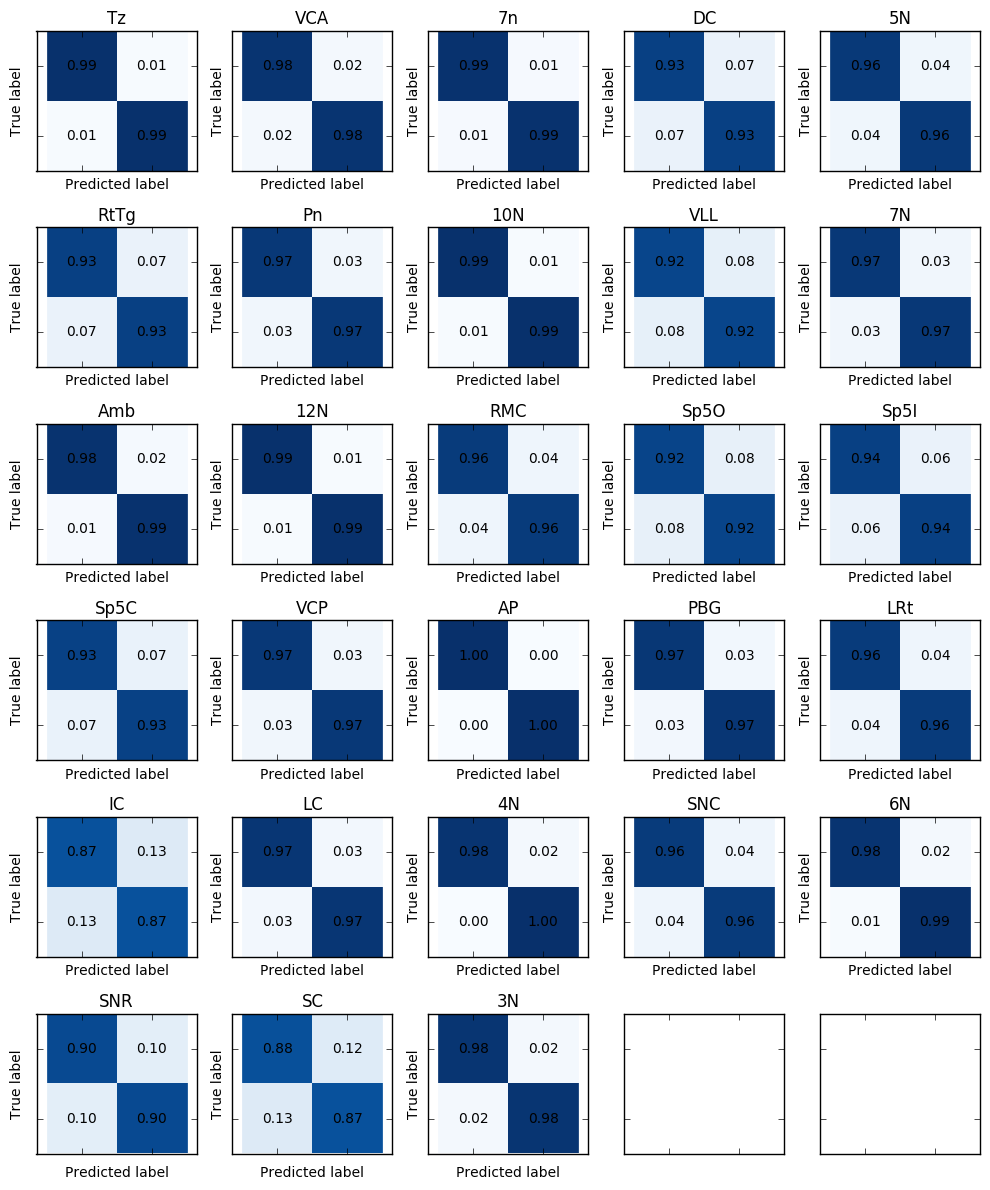

In [74]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]            
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[label] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [75]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.957362878821


In [ ]:
# visualize training patches

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')
display_images_in_grids(patches, 5)

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)